In [126]:
import os, sys, json
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from collections import defaultdict
from tabulate import tabulate
from IPython.core.display import display, HTML

# Increase display width
display(HTML("<style>.container { width:80% !important; }</style>"))

# Some styling
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 10

In [127]:
##### We reuse these over and over and it's easier to have them in a list than unordered dict
model_names = ["wgan", "wgpgan", "nsgan", "mmgan", "ragan", 
               "lsgan", "dragan", "began", "infogan", "fishergan", 
               "fgan_forward_kl", "fgan_reverse_kl", "fgan_jensen_shannon",
               "fgan_total_var", "fgan_hellinger", "fgan_pearson"]
plot_names = ['WGAN', 'WGANGP', 'NSGAN', 'MMGAN', 'RAGAN', 'LSGAN', 'DRAGAN', 'BEGAN', 'InfoGAN',
              'FisherGAN','ForwGAN', 'RevGAN', 'JSGAN', 'TVGAN', 'HellingerGAN', 'PearsonGAN']
distance_metrics=["KL-Divergence", "Jensen-Shannon", "Wasserstein-Distance"]#, "Energy-Distance"]
distributions=['normal', 'beta', 'gumbel', 'laplace', 'exponential', 'gamma']

# Colors
palette = ["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", "#98df8a", "#d62728", "#ff9896", "#9467bd",
            "#c5b0d5", "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", "#c7c7c7", "#bcbd22" "#dbdb8d",
            "#17becf", "#9edae5"]

# For subplotting
plt_idx = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

    
def graph_multivariate(optimal, 
                       ci=True,
                       omit_outliers=True,
                       thresh=8.5,
                       plt_idx=plt_idx,
                       model_names=model_names,
                       distance_metrics=distance_metrics,
                       distributions=distributions,
                       palette=palette):
    
    for metric in distance_metrics:

        fig, axes = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(20,20))

        for d_idx, distribution in enumerate(distributions):

            for idx, model_name in enumerate(model_names):

                if model_name in ['vae', 'autoencoder']:
                    continue
                    
                data = optimal[model_name][distribution][metric]['mean']
                
                if omit_outliers:
                    # Remove outliers
                    orig_data = np.array(data)
                    notnan_indexes = ~np.isnan(orig_data)
                    outlier_indexes = is_outlier(orig_data[notnan_indexes], thresh=thresh)
                    data = orig_data.flatten()[~outlier_indexes]
                    
                    x = np.linspace(0, orig_data.shape[0], data.shape[0])
                    high = data + np.array(optimal[model_name][distribution][metric]['h']).flatten()[~outlier_indexes]
                    low = data - np.array(optimal[model_name][distribution][metric]['h']).flatten()[~outlier_indexes]

                else:
                    
                    x = range(0, len(data))
                    high = data + np.array(optimal[model_name][distribution][metric]['h'])
                    low = data - np.array(optimal[model_name][distribution][metric]['h'])
                    
                axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].plot(x,
                                                                data,
                                                                label=plot_names[idx],
                                                                c=palette[idx])
                                    
                if ci == True:
                    axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].fill_between(x,
                                                                            high,
                                                                            low,
                                                                            facecolor=palette[idx],
                                                                            alpha=0.3)

        plt.ylim(bottom=0)
        fig.suptitle("{0}".format(metric), x=0.5, y=0.93, fontsize=18)
        fig.text(0.5, 0.08, "Epoch", ha='center', fontsize=16)
        plt.legend(loc='center left', bbox_to_anchor=(1, 1), fontsize=18)
        plt.show()
#         plt.savefig('../graphs/multivariate/{0}_{1}_{2}.png'.format(metric, dims, samples), dpi=100)

def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


def nested_pickle_dict():
    """ Picklable defaultdict nested dictionaries """
    return defaultdict(nested_pickle_dict)


def mean_confidence_interval(data, axis=0, confidence=0.95):
#     try:
    n = data.shape[axis]
#     except IndexError:
#         axis = 0
#         n = data.shape[axis]

    mu, std = np.nanmean(data, axis=axis), scipy.stats.sem(data, axis=axis, nan_policy='omit')
    h = np.ma.getdata(std) * scipy.stats.t.ppf((1 + confidence) / 2., n-1)       

    return mu, h, mu-h, mu+h


def load_best(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
        
    return data

In [128]:
optimal_1000 = load_best('/Users/sob/Desktop/gan_results/best_1024/multivariate/128_dims_1000_samples/data.json')
optimal_10000 = load_best('/Users/sob/Desktop/gan_results/best_1024/multivariate/128_dims_10000_samples/data.json')
optimal_100000 = load_best('/Users/sob/Desktop/gan_results/best_1024/multivariate/128_dims_100000_samples/data.json')

 Plot mean performance across epochs for 1k samples


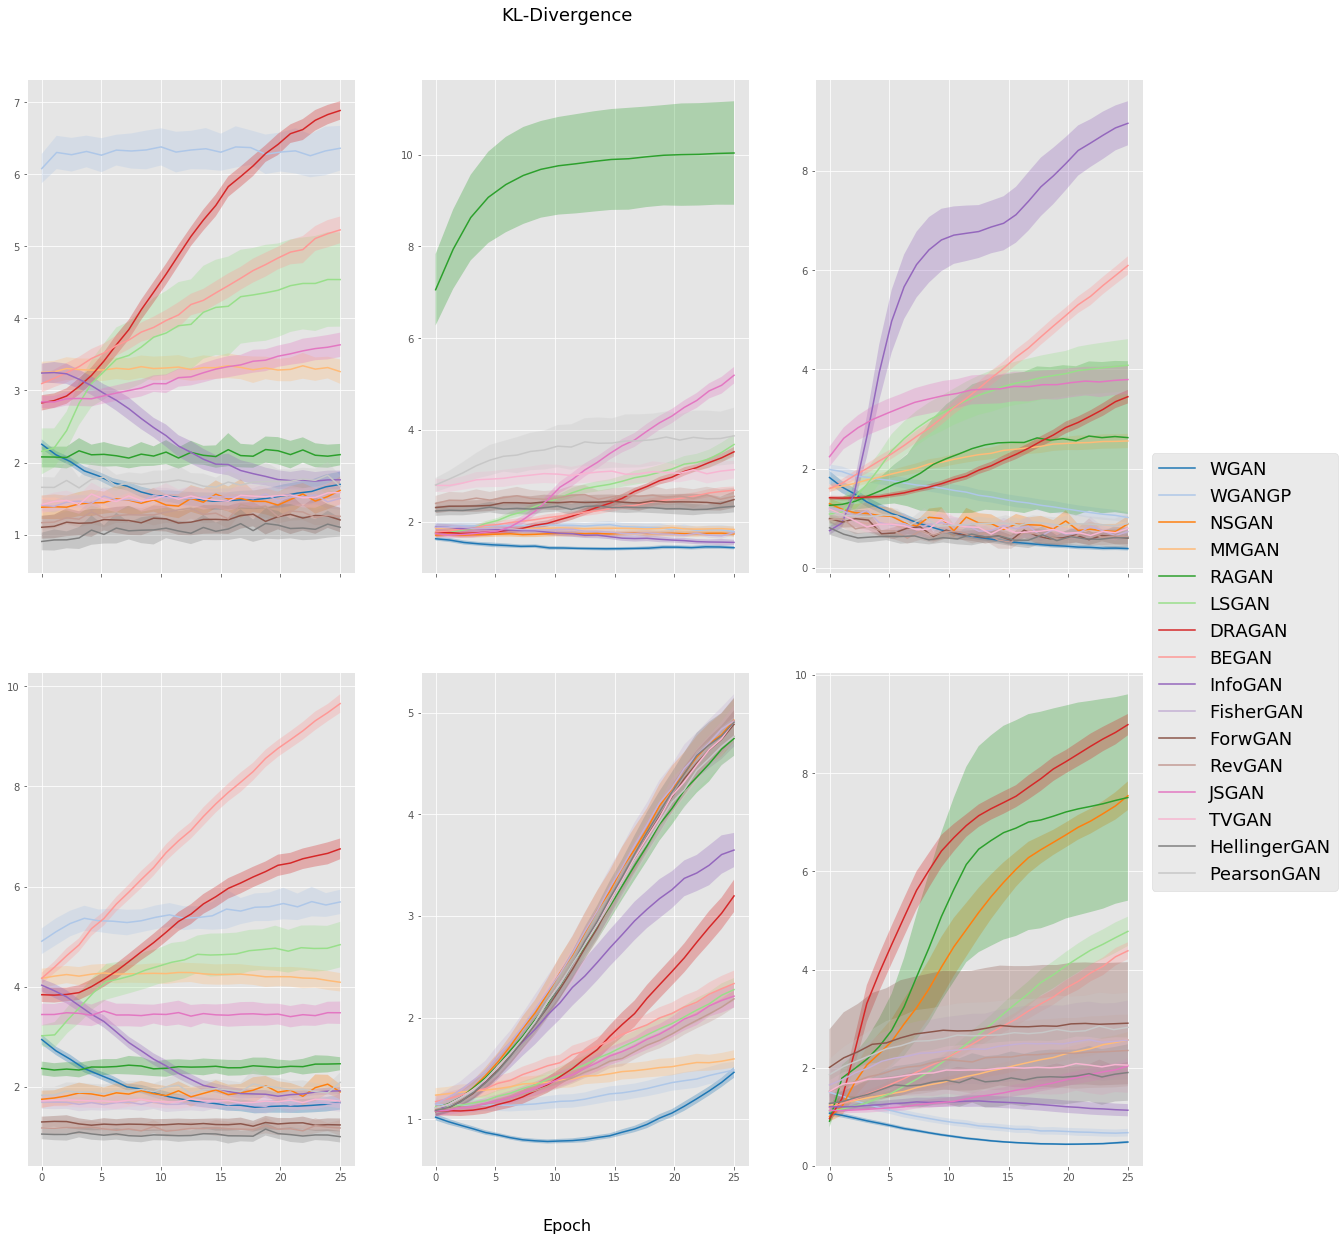

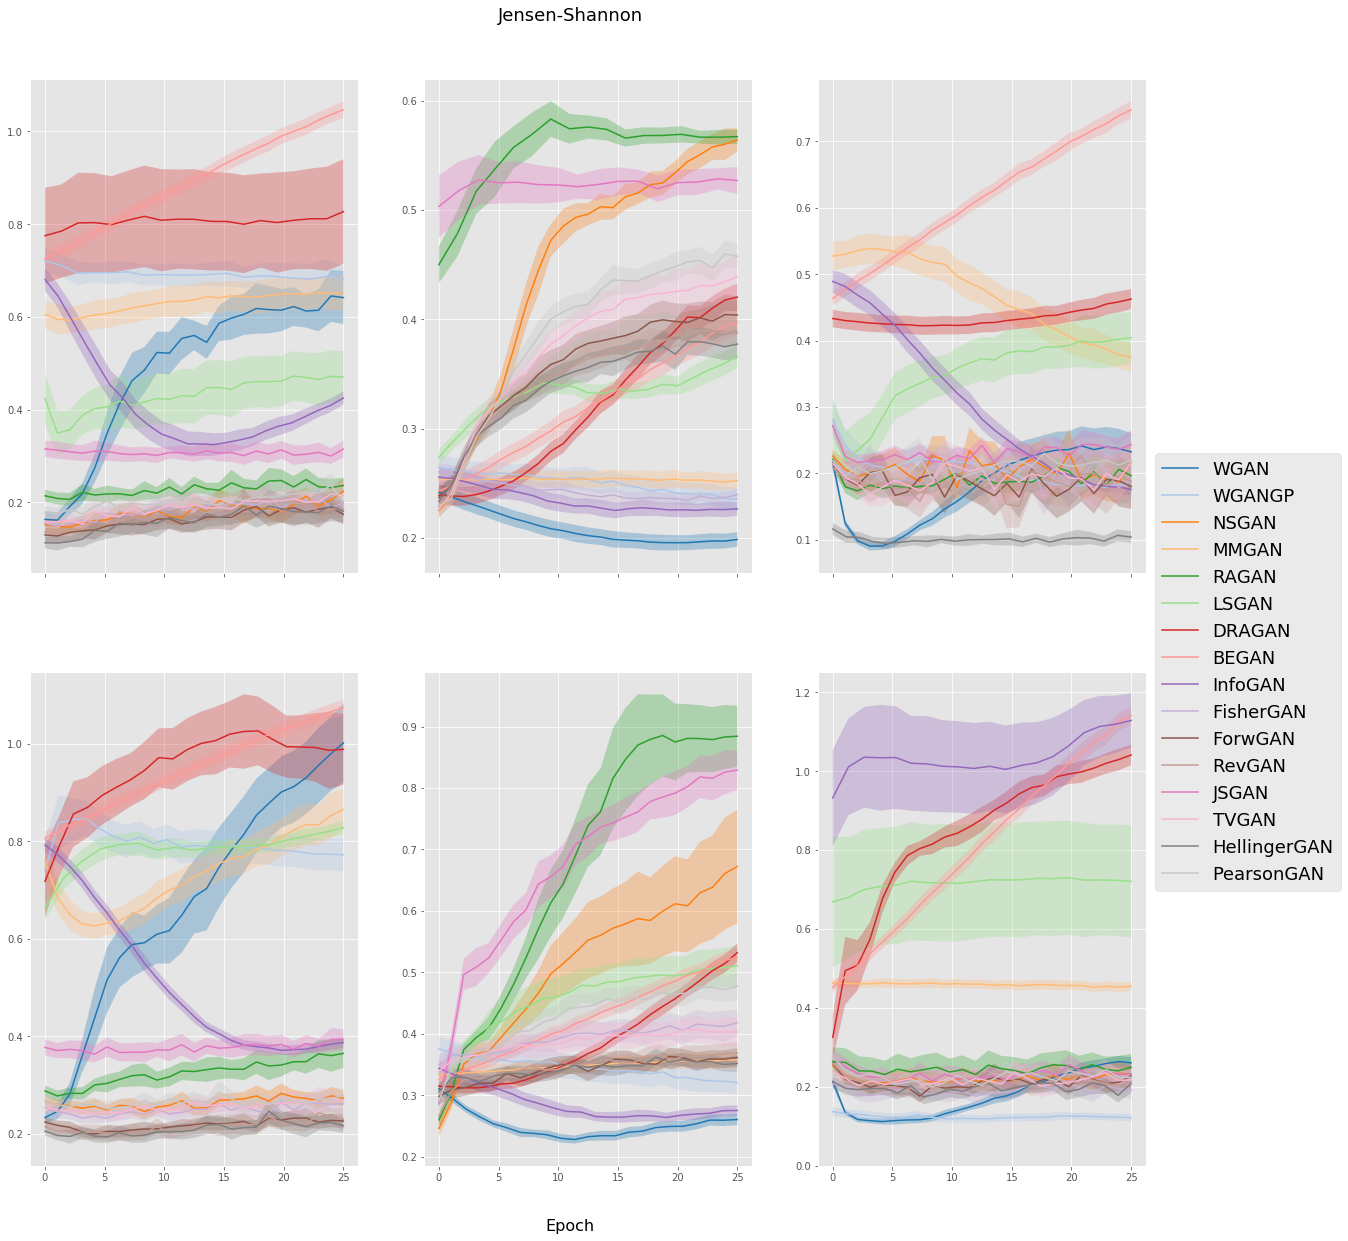

/Users/sob/github/gans6883/env/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide
/Users/sob/github/gans6883/env/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in greater


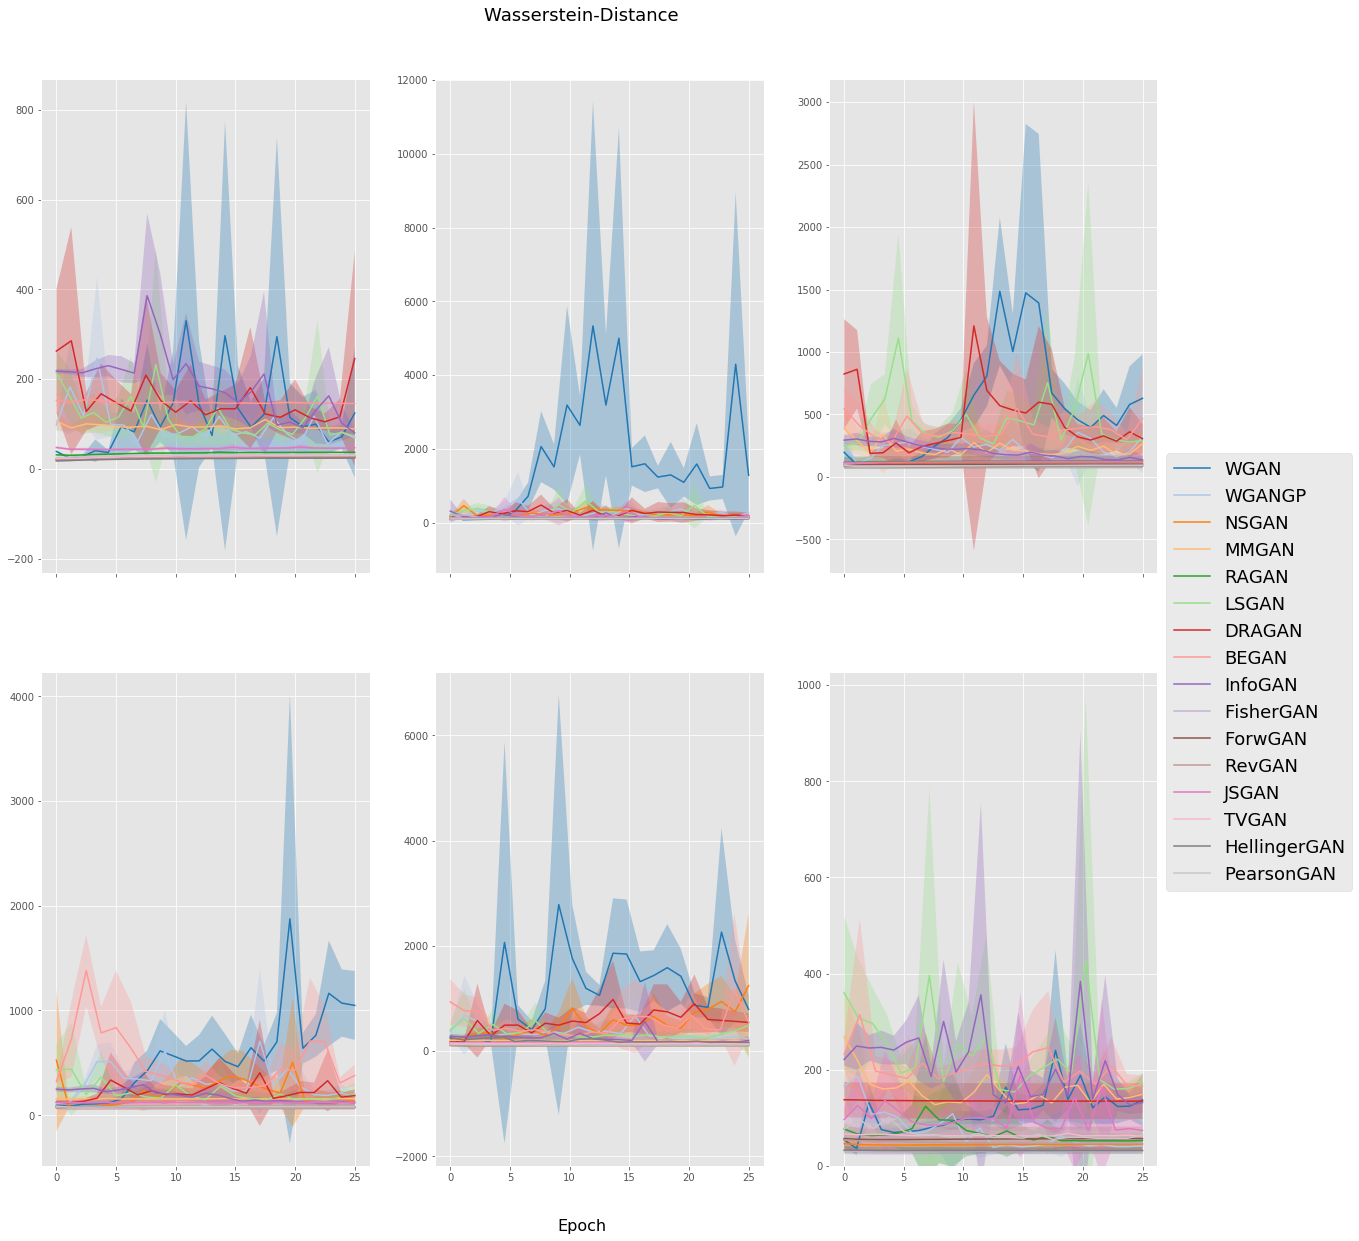

In [115]:
print(""" Plot mean performance across epochs for 1k samples""")
graph_multivariate(optimal_1000, ci=True, omit_outliers=True, thresh=4.5)

 Plot mean performance across epochs for 10k samples


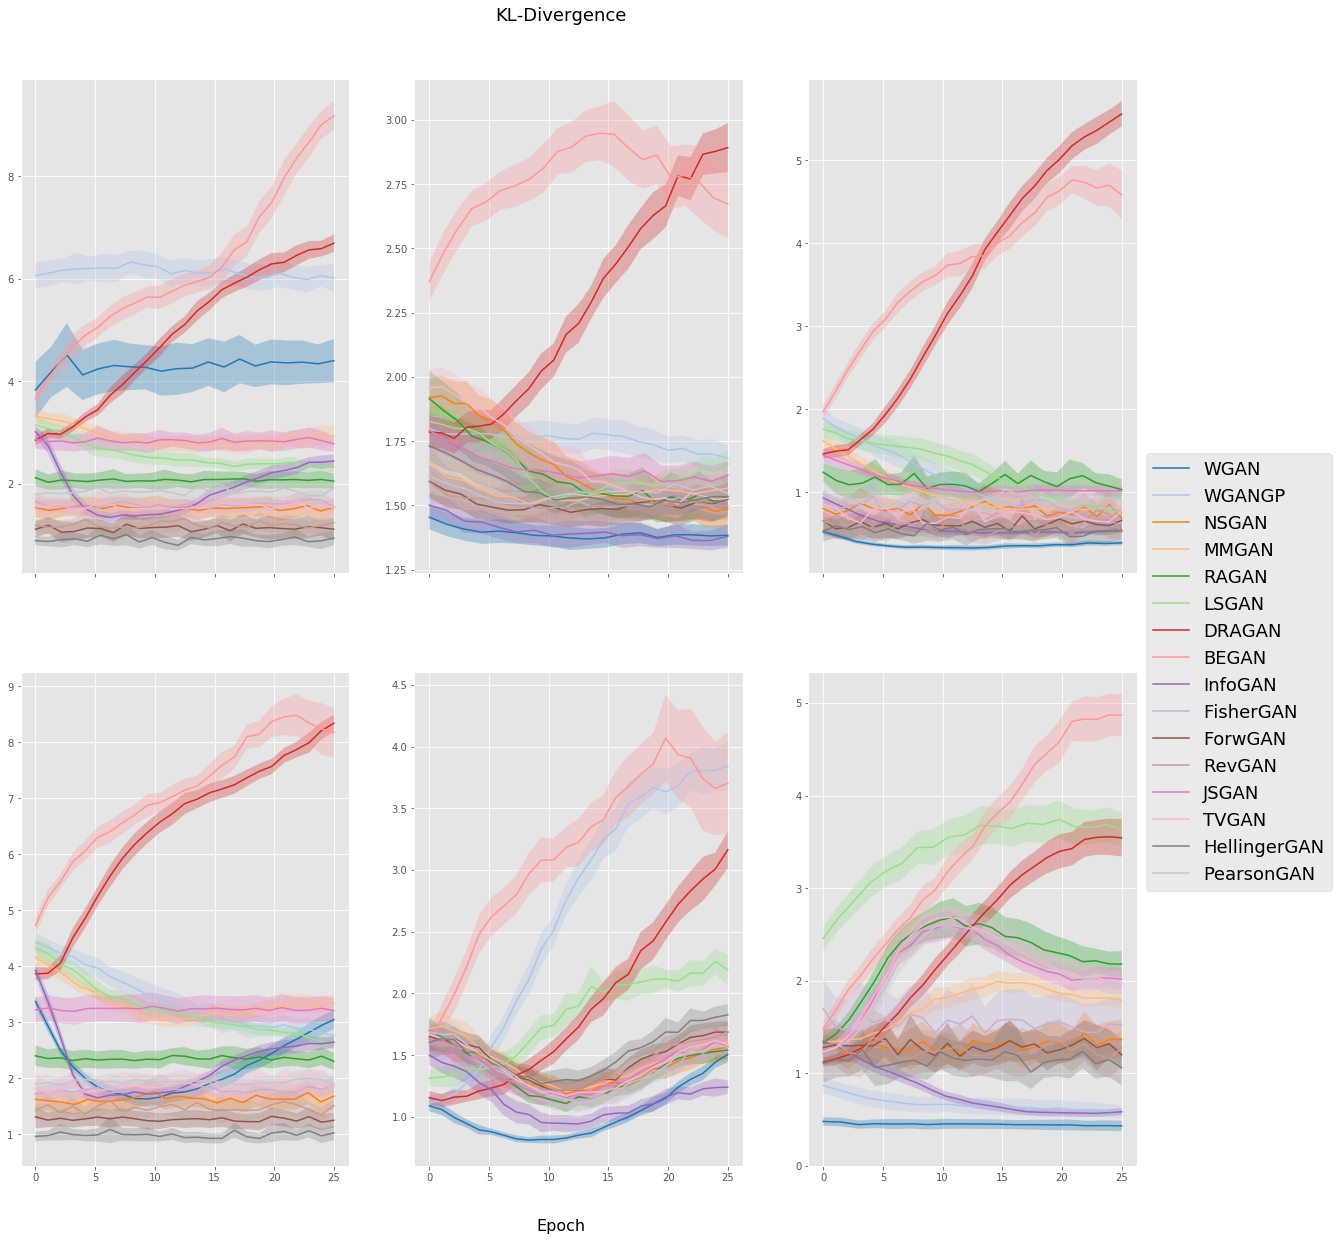

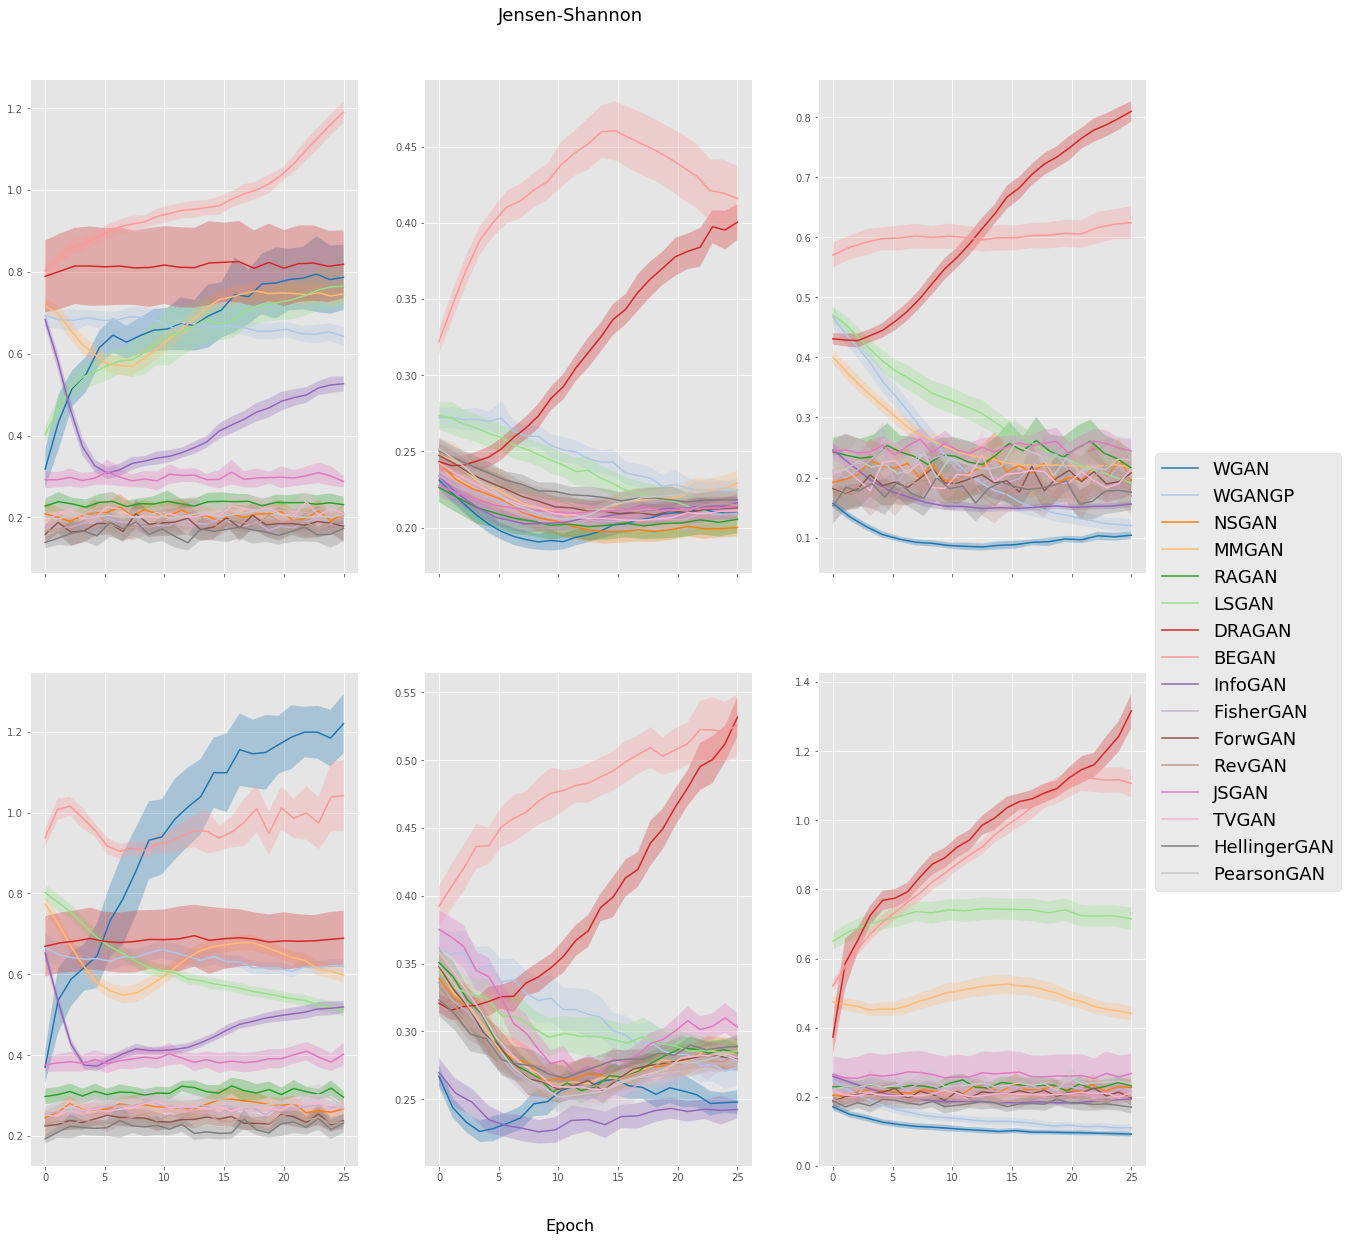

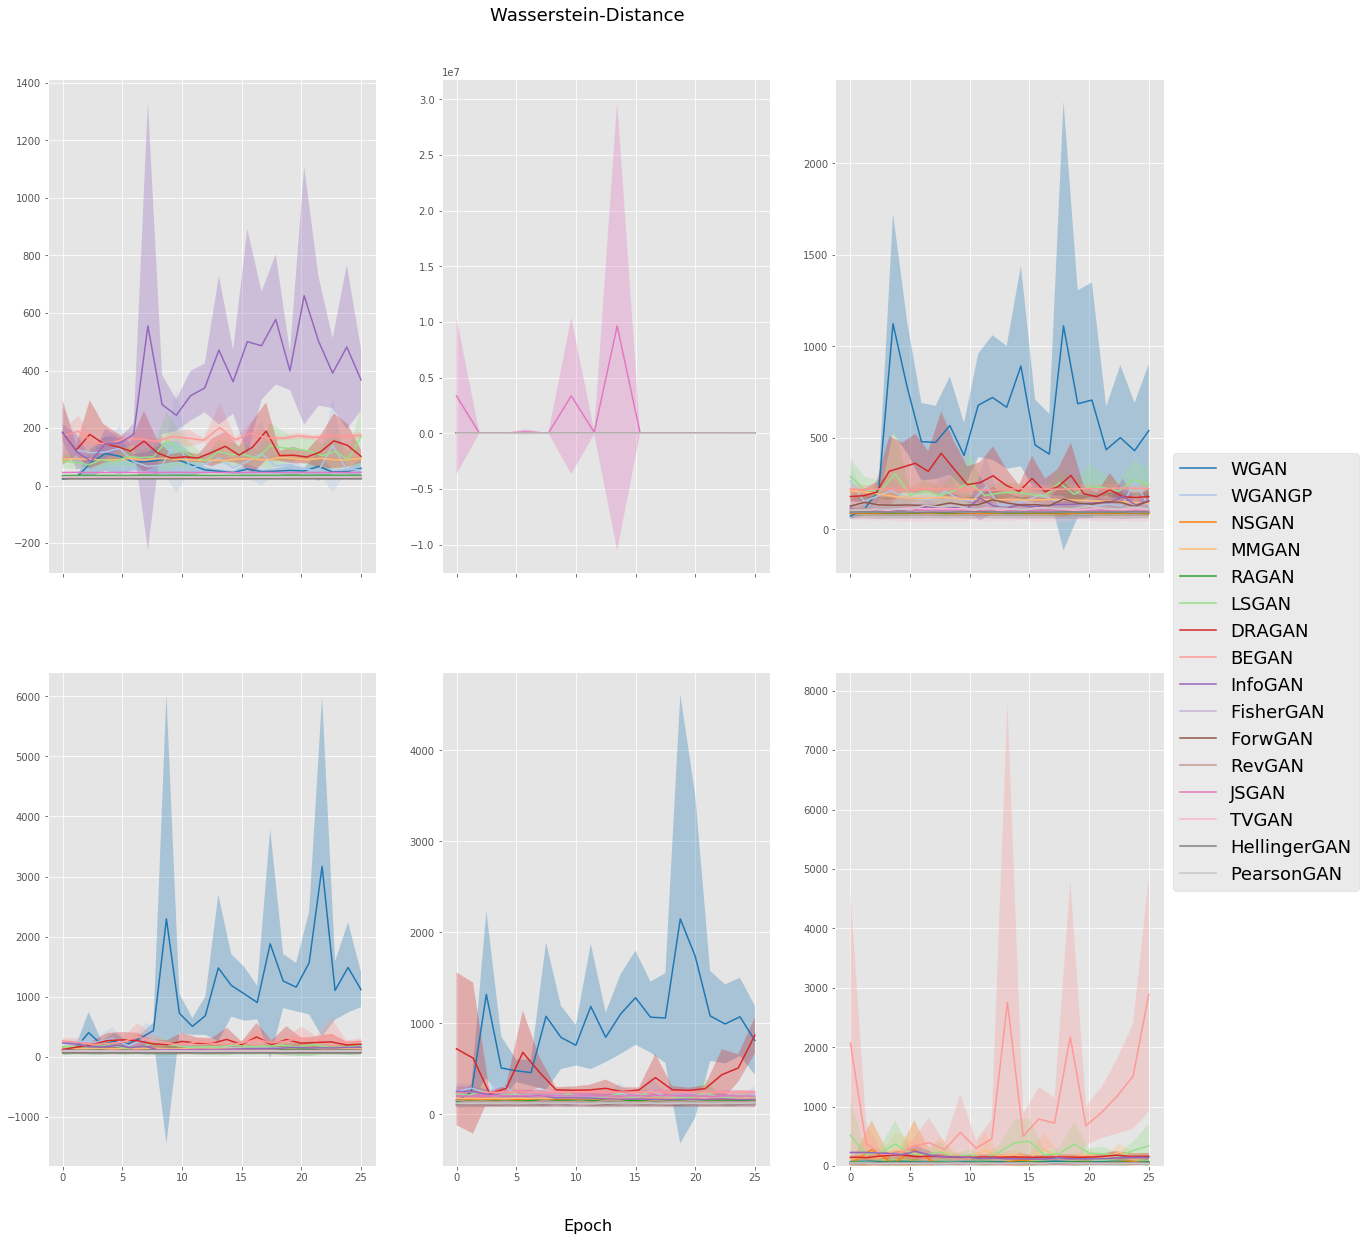

In [125]:
print(""" Plot mean performance across epochs for 10k samples""")
graph_multivariate(optimal_10000, ci=True, omit_outliers=True, thresh=3.0)

 Plot mean performance across epochs for 100k samples


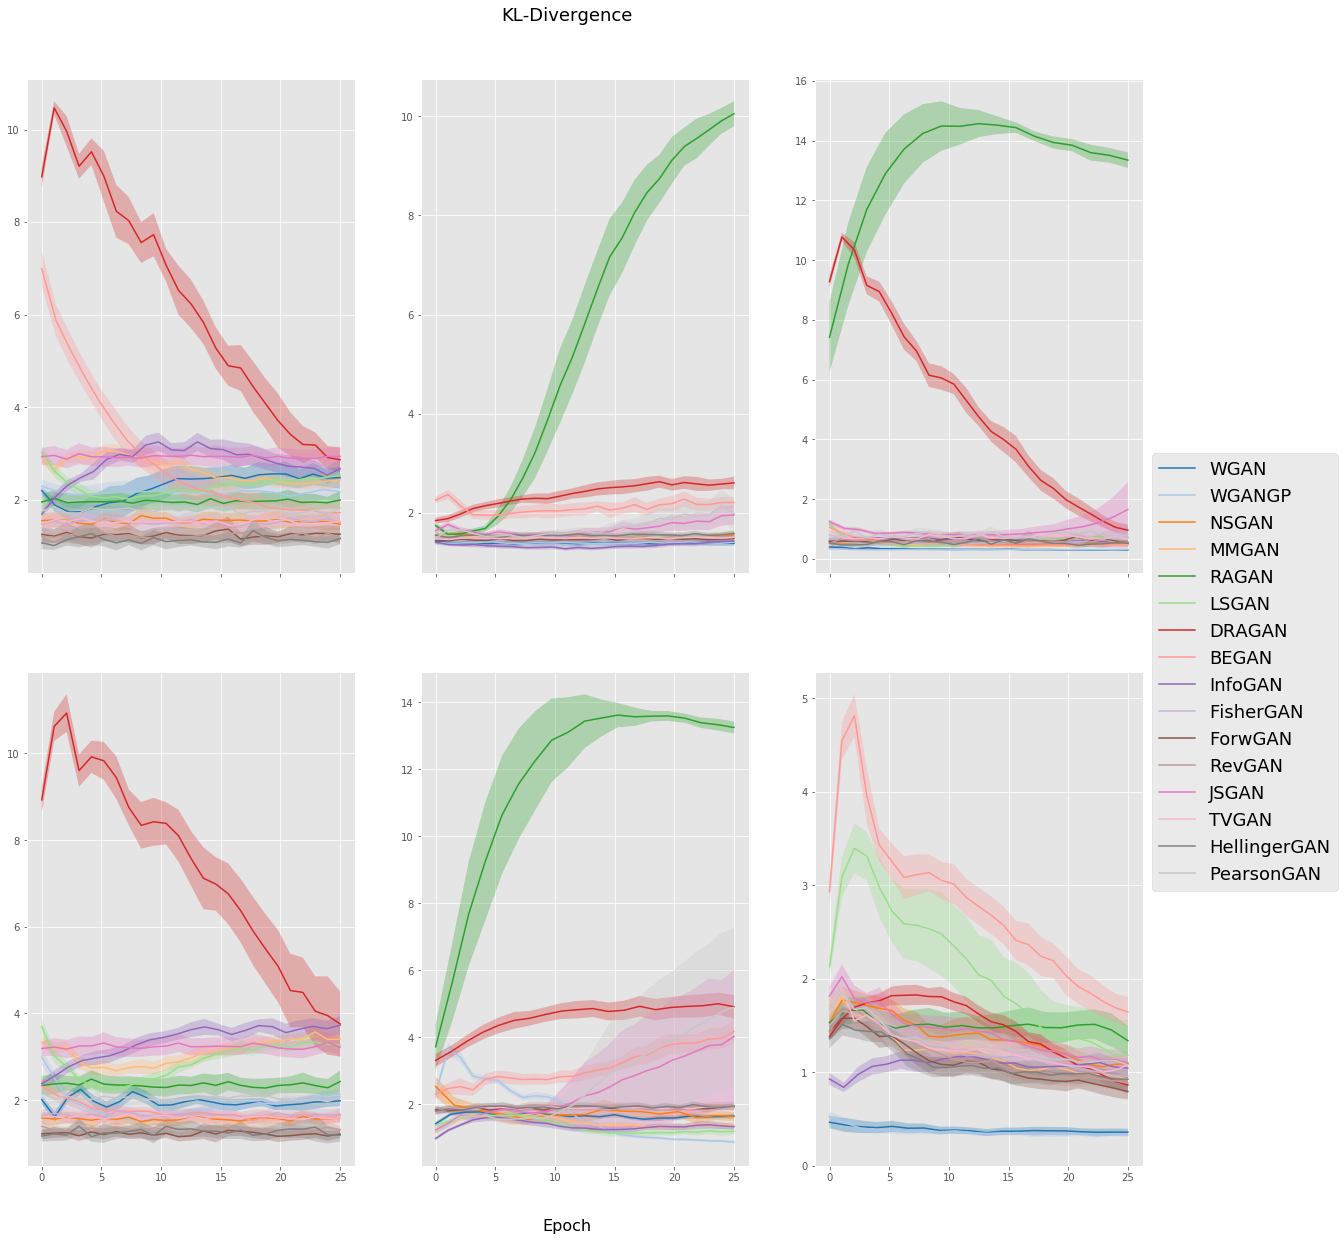

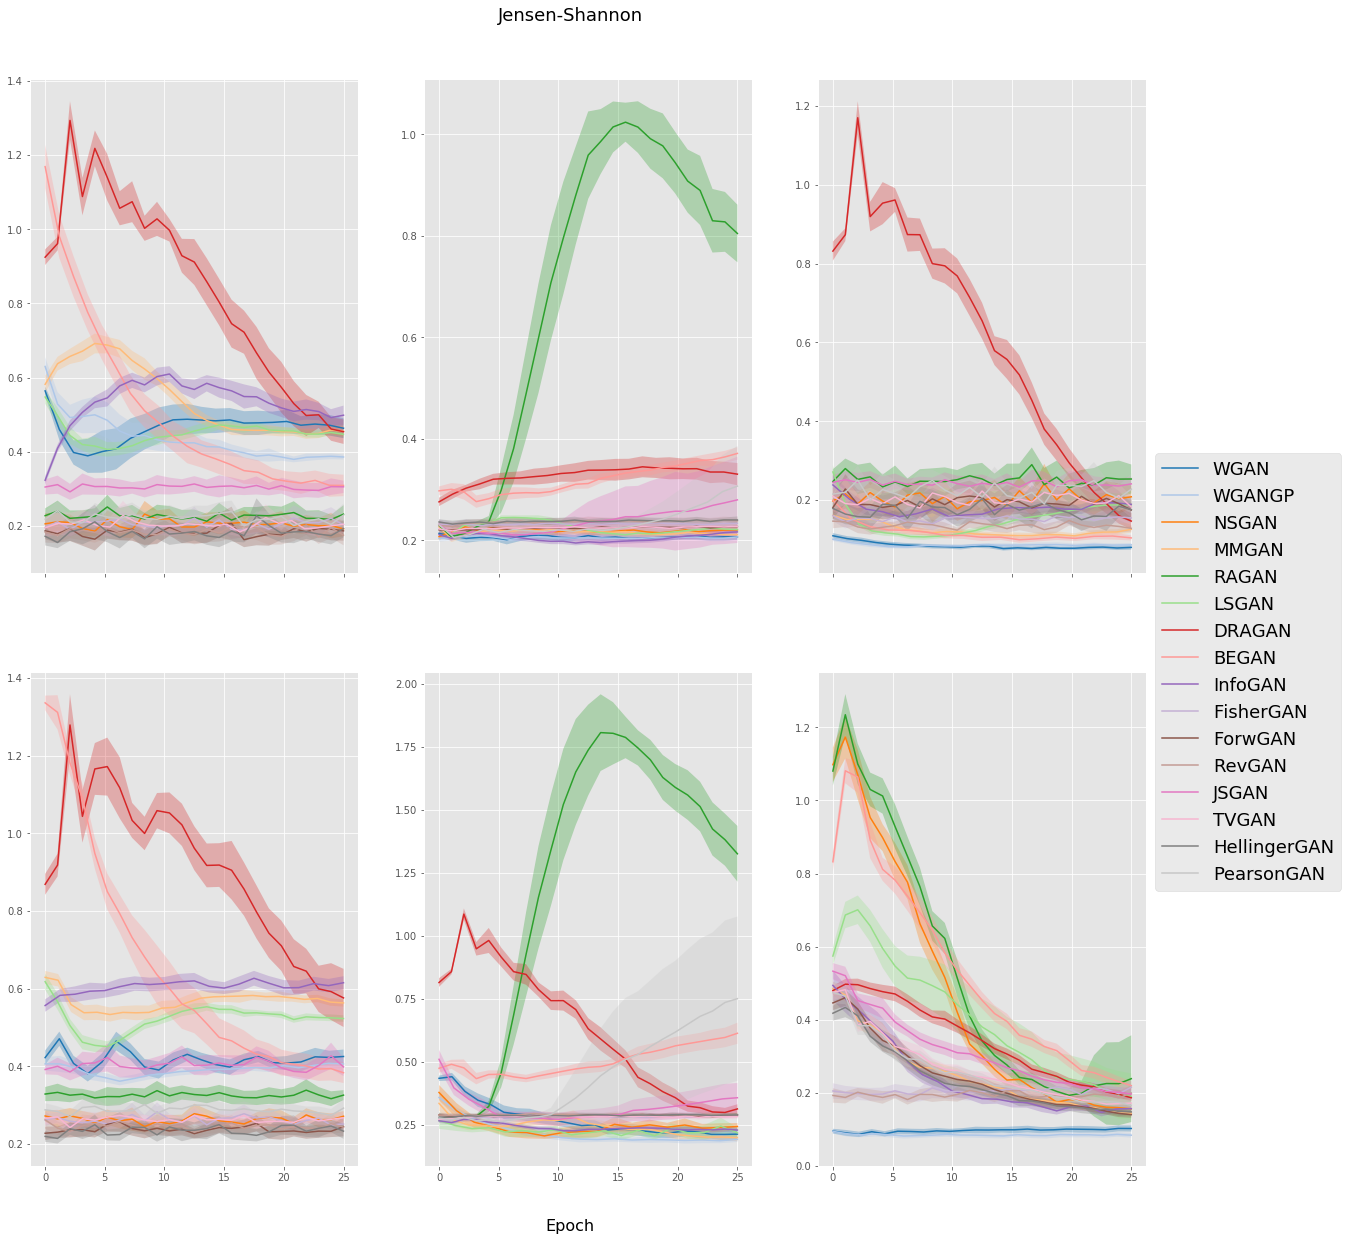

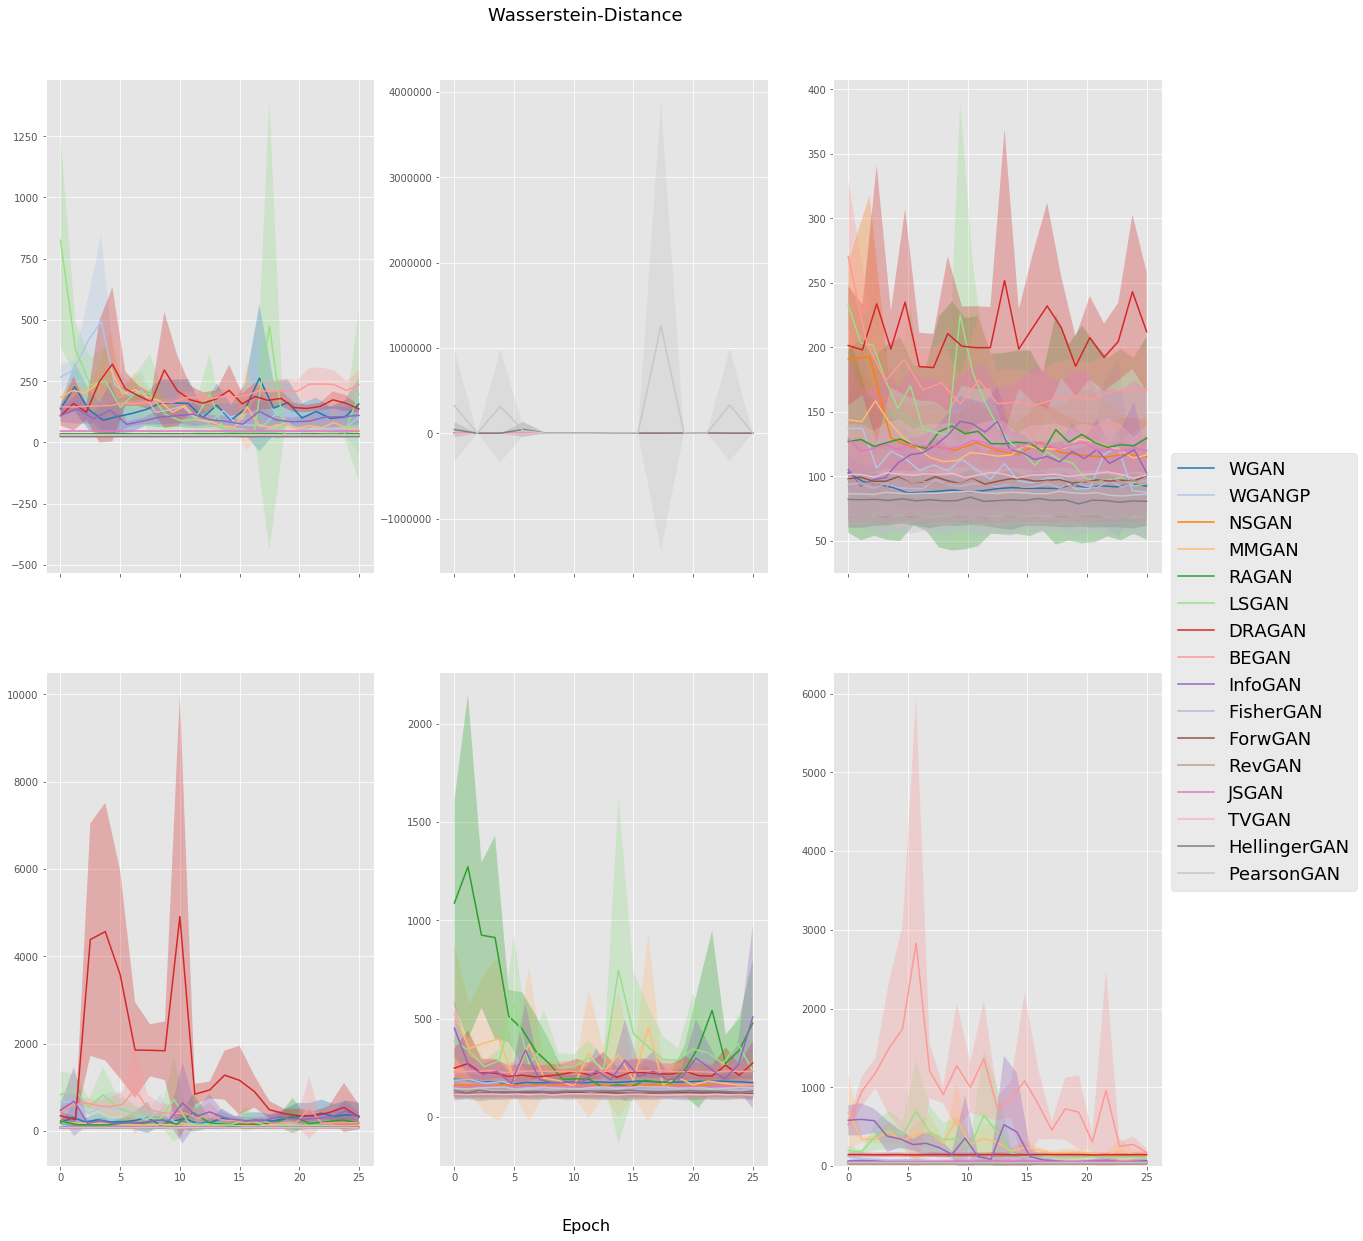

In [117]:
print(""" Plot mean performance across epochs for 100k samples""")
graph_multivariate(optimal_100000, ci=True, omit_outliers=True, thresh=4.5)

In [118]:
# print(""" Print confidence intervals for minimum across all runs """)
# optimal_1000 = load_best('/Users/sob/Desktop/gan_results/best_hyper/multivariate/128_dims_1000_samples/data.json')
# optimal_10000 = load_best('/Users/sob/Desktop/gan_results/best_hyper/multivariate/128_dims_10000_samples/data.json')
# optimal_100000 = load_best('/Users/sob/Desktop/gan_results/best_hyper/multivariate/128_dims_100000_samples/data.json')

rankings_dict = nested_pickle_dict()
param_dict = nested_pickle_dict()

for metric in distance_metrics:
    
    print('\n======================')
    print('{0}'.format(metric))
    print('======================\n')
        
    for samples, optimal in [(1000, optimal_1000), (10000, optimal_10000), (100000, optimal_100000)]:
        
#         print('\n{0} Samples \n'.format(samples))

        for distribution in distributions:

            for model_name in model_names:
                
                minimums = np.nanmin(np.array(optimal[model_name][distribution][metric]['values']), axis=1)
                mu, h, low, high = mean_confidence_interval(minimums)
                param_dict[metric][model_name][distribution][samples] = '%.3f ± %.3f' % (np.round(mu, 3), np.round(h, 3))
        
        data = [[key, param_dict[metric][key]['normal'][samples], param_dict[metric][key]['beta'][samples], 
                      param_dict[metric][key]['gumbel'][samples], param_dict[metric][key]['laplace'][samples], 
                      param_dict[metric][key]['exponential'][samples], param_dict[metric][key]['gamma'][samples]]
                 for key in model_names]
        print(tabulate(data, headers=['Model', 'Normal', 'Beta', 'Gumbel', 'Laplace', 'Exponential', 'Gamma'], tablefmt='fancy_grid'), '\n')
        
        rankings = np.argsort([[eval(i[:4]) if i[:4] != 'nan ' else 1e10 for i in j[1:]] for j in data], axis=0)
        
        for j in range(rankings.shape[1]):
            for idx, name in enumerate(rankings[:, j]):
                if model_names[name] not in rankings_dict[metric][distributions[j]]:
                    rankings_dict[metric][distributions[j]][model_names[name]] = []
                rankings_dict[metric][distributions[j]][model_names[name]].append(idx)


KL-Divergence

╒═════════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│ Model               │ Normal        │ Beta          │ Gumbel        │ Laplace       │ Exponential   │ Gamma         │
╞═════════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ wgan                │ 1.398 ± 0.110 │ 1.370 ± 0.034 │ 0.380 ± 0.039 │ 1.545 ± 0.114 │ 0.774 ± 0.021 │ 0.432 ± 0.019 │
├─────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ wgpgan              │ 1.913 ± 0.214 │ 1.710 ± 0.072 │ 1.010 ± 0.104 │ 2.775 ± 0.234 │ 1.109 ± 0.055 │ 0.655 ± 0.073 │
├─────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ nsgan               │ 1.276 ± 0.160 │ 1.655 ± 0.053 │ 0.484 ± 0.099 │ 1.647 ± 0.168 │ 1.092 ± 0.043 │ 0.989 ± 0.110 │
├─────────────────────┼─

╒═════════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│ Model               │ Normal        │ Beta          │ Gumbel        │ Laplace       │ Exponential   │ Gamma         │
╞═════════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ wgan                │ 0.341 ± 0.034 │ 0.192 ± 0.006 │ 0.068 ± 0.003 │ 0.349 ± 0.016 │ 0.192 ± 0.017 │ 0.081 ± 0.006 │
├─────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ wgpgan              │ 0.359 ± 0.008 │ 0.198 ± 0.005 │ 0.074 ± 0.004 │ 0.353 ± 0.009 │ 0.177 ± 0.008 │ 0.075 ± 0.006 │
├─────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ nsgan               │ 0.148 ± 0.010 │ 0.205 ± 0.005 │ 0.094 ± 0.009 │ 0.214 ± 0.011 │ 0.176 ± 0.010 │ 0.143 ± 0.008 │
├─────────────────────┼───────────────┼─

In [120]:
print(""" Print confidence intervals for minimum across all runs """)

for metric in distance_metrics:
    
    print('\n======================')
    print('{0}'.format(metric))
    print('======================\n')
                
    for distribution in distributions:
        
        for model_name in model_names:
            
            param_dict[metric][model_name][distribution]['performance'] = ''
        
            for samples, optimal in [(1000, optimal_1000), (10000, optimal_10000), (100000, optimal_100000)]:
                        
                minimums = np.nanmin(np.array(optimal[model_name][distribution][metric]['values']), axis=1)
                mu, h, low, high = mean_confidence_interval(minimums)
                param_dict[metric][model_name][distribution]['performance'] += '%.3f ± %.3f\n' % (np.round(mu, 3), np.round(h, 3))
        
    data = [[key, param_dict[metric][key]['normal']['performance'], param_dict[metric][key]['beta']['performance'], 
                  param_dict[metric][key]['gumbel']['performance'], param_dict[metric][key]['laplace']['performance'], 
                  param_dict[metric][key]['exponential']['performance'], param_dict[metric][key]['gamma']['performance']]
             for key in model_names]
    
    print(tabulate(data, headers=['Model', 'Normal', 'Beta', 'Gumbel', 'Laplace', 'Exponential', 'Gamma'], tablefmt='fancy_grid'), '\n')

 Print confidence intervals for minimum across all runs 

KL-Divergence

╒═════════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│ Model               │ Normal        │ Beta          │ Gumbel        │ Laplace       │ Exponential   │ Gamma         │
╞═════════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ wgan                │ 1.398 ± 0.110 │ 1.370 ± 0.034 │ 0.380 ± 0.039 │ 1.545 ± 0.114 │ 0.774 ± 0.021 │ 0.432 ± 0.019 │
│                     │ 1.368 ± 0.155 │ 1.324 ± 0.037 │ 0.309 ± 0.024 │ 1.566 ± 0.124 │ 0.780 ± 0.020 │ 0.387 ± 0.047 │
│                     │ 1.501 ± 0.183 │ 1.314 ± 0.047 │ 0.268 ± 0.012 │ 1.585 ± 0.113 │ 0.816 ± 0.035 │ 0.330 ± 0.032 │
├─────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ wgpgan              │ 1.913 ± 0.214 │ 1.710 ± 0.072 │ 1.010 ± 0.104 │ 2.775 ± 0.234 │

╒═════════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│ Model               │ Normal        │ Beta          │ Gumbel        │ Laplace       │ Exponential   │ Gamma         │
╞═════════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ wgan                │ 0.157 ± 0.017 │ 0.194 ± 0.007 │ 0.085 ± 0.006 │ 0.229 ± 0.013 │ 0.222 ± 0.007 │ 0.106 ± 0.007 │
│                     │ 0.152 ± 0.014 │ 0.188 ± 0.005 │ 0.079 ± 0.005 │ 0.251 ± 0.017 │ 0.216 ± 0.006 │ 0.086 ± 0.006 │
│                     │ 0.341 ± 0.034 │ 0.192 ± 0.006 │ 0.068 ± 0.003 │ 0.349 ± 0.016 │ 0.192 ± 0.017 │ 0.081 ± 0.006 │
├─────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ wgpgan              │ 0.219 ± 0.020 │ 0.230 ± 0.010 │ 0.166 ± 0.016 │ 0.385 ± 0.022 │ 0.312 ± 0.019 │ 0.112 ± 0.010 │
│                     │ 0.295 ± 0.019 │ 

In [123]:
print(""" Get relative ranking performance based on mean minimum performance\n """)


print('0 is the best performance.\n1st entry: 1k samples, 2nd: 10k, 3rd: 100k \n')
for metric in distance_metrics:
    print('========{0}=======\n'.format(metric))
    
    print(tabulate([[key, rankings_dict[metric]['normal'][key], rankings_dict[metric]['beta'][key], rankings_dict[metric]['gumbel'][key],
                          rankings_dict[metric]['laplace'][key], rankings_dict[metric]['exponential'][key], rankings_dict[metric]['gamma'][key]] 
                    for key in model_names], 
                   headers=['Model', 'Normal', 'Beta', 'Gumbel', 'Laplace', 'Exponential', 'Gamma']), '\n')

 Get relative ranking performance based on mean minimum performance
 
0 is the best performance.
1st entry: 1k samples, 2nd: 10k, 3rd: 100k 

========KL-Divergence=======

Model                Normal        Beta          Gumbel        Laplace       Exponential    Gamma
-------------------  ------------  ------------  ------------  ------------  -------------  ------------
wgan                 [6, 6, 7]     [0, 1, 1]     [3, 3, 1]     [4, 7, 8]     [0, 0, 0]      [0, 0, 1]
wgpgan               [9, 10, 10]   [11, 13, 2]   [11, 9, 3]    [11, 11, 6]   [8, 6, 1]      [1, 2, 0]
nsgan                [3, 5, 6]     [4, 3, 6]     [6, 5, 9]     [6, 3, 3]     [7, 9, 6]      [10, 6, 12]
mmgan                [15, 12, 13]  [15, 8, 4]    [14, 10, 5]   [14, 12, 13]  [15, 11, 4]    [15, 14, 6]
ragan                [10, 9, 11]   [9, 9, 13]    [8, 12, 14]   [9, 9, 11]    [9, 3, 11]     [8, 12, 14]
lsgan                [11, 11, 12]  [13, 11, 7]   [12, 11, 6]   [10, 10, 12]  [10, 14, 2]    [12, 13, 9]
draga

 Plot mean minimum performance with error bars as a function of number samples 


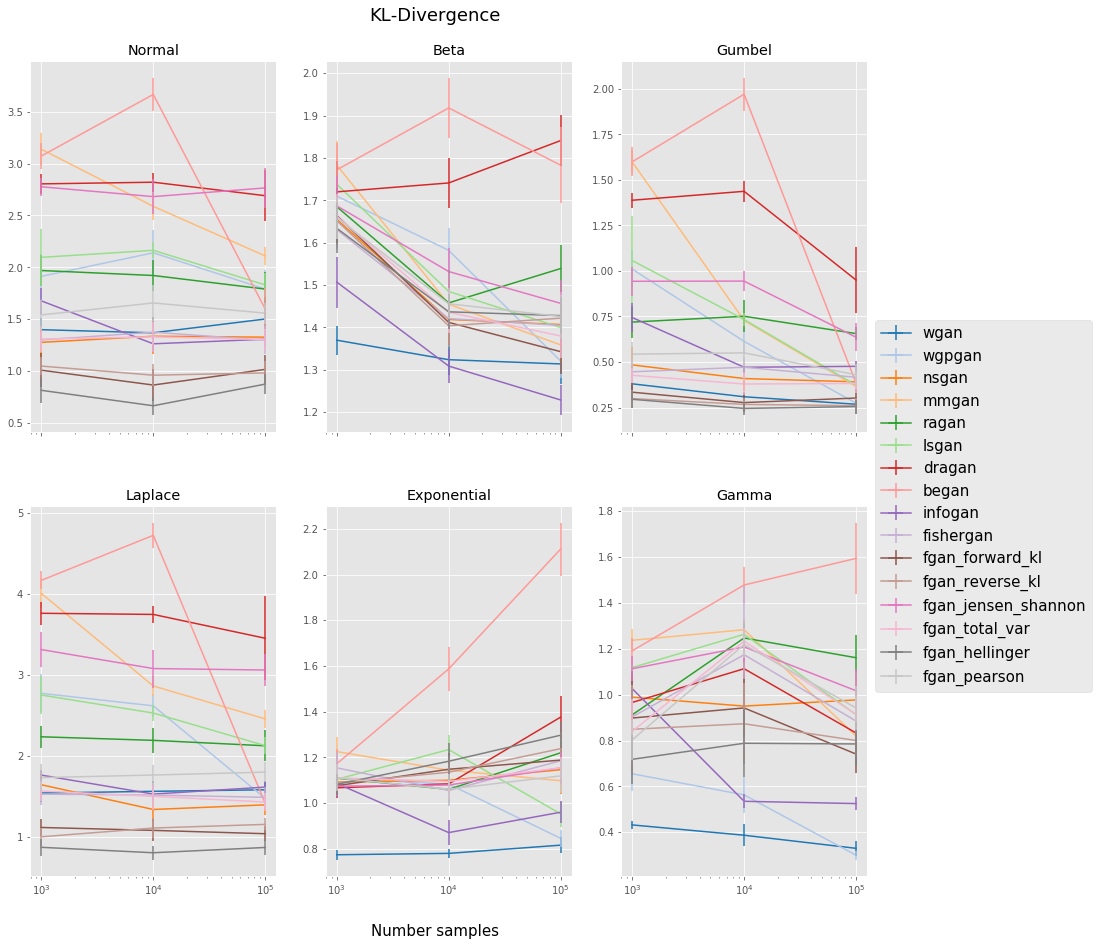

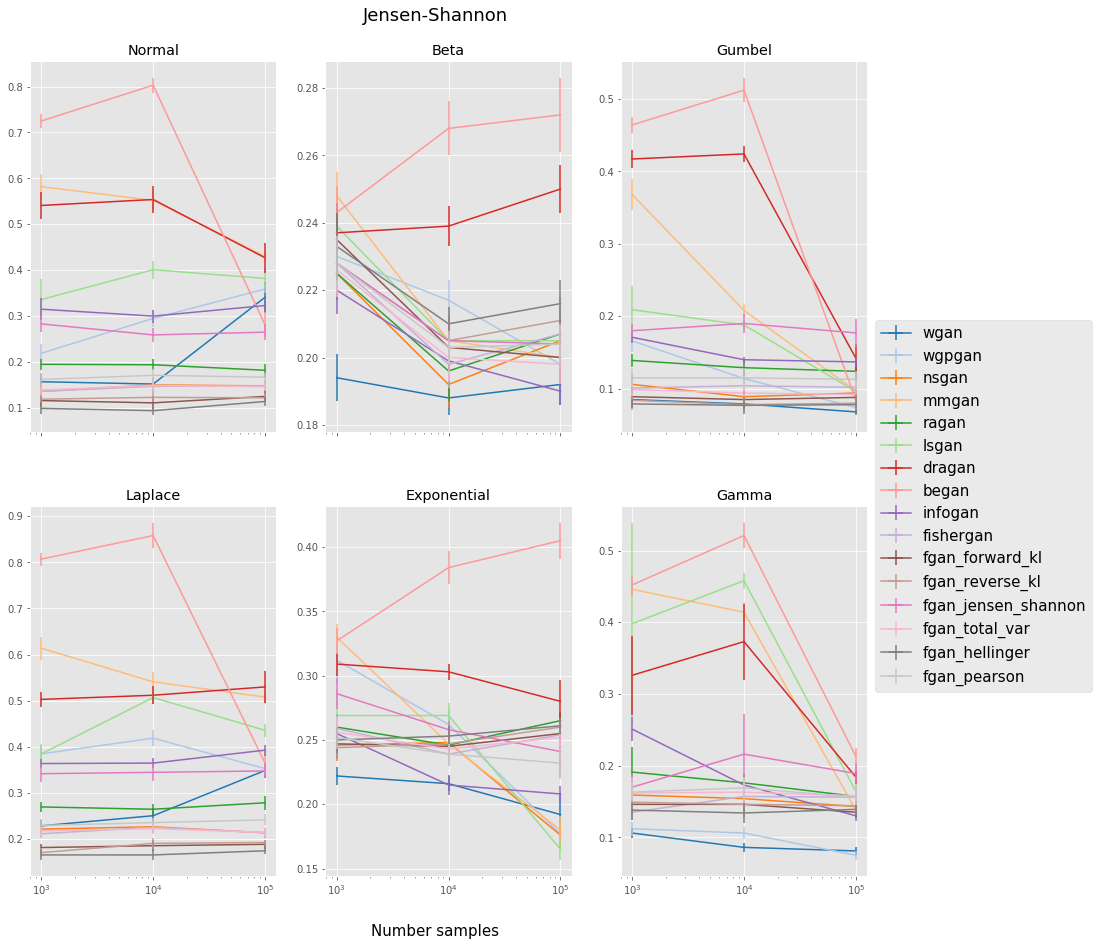

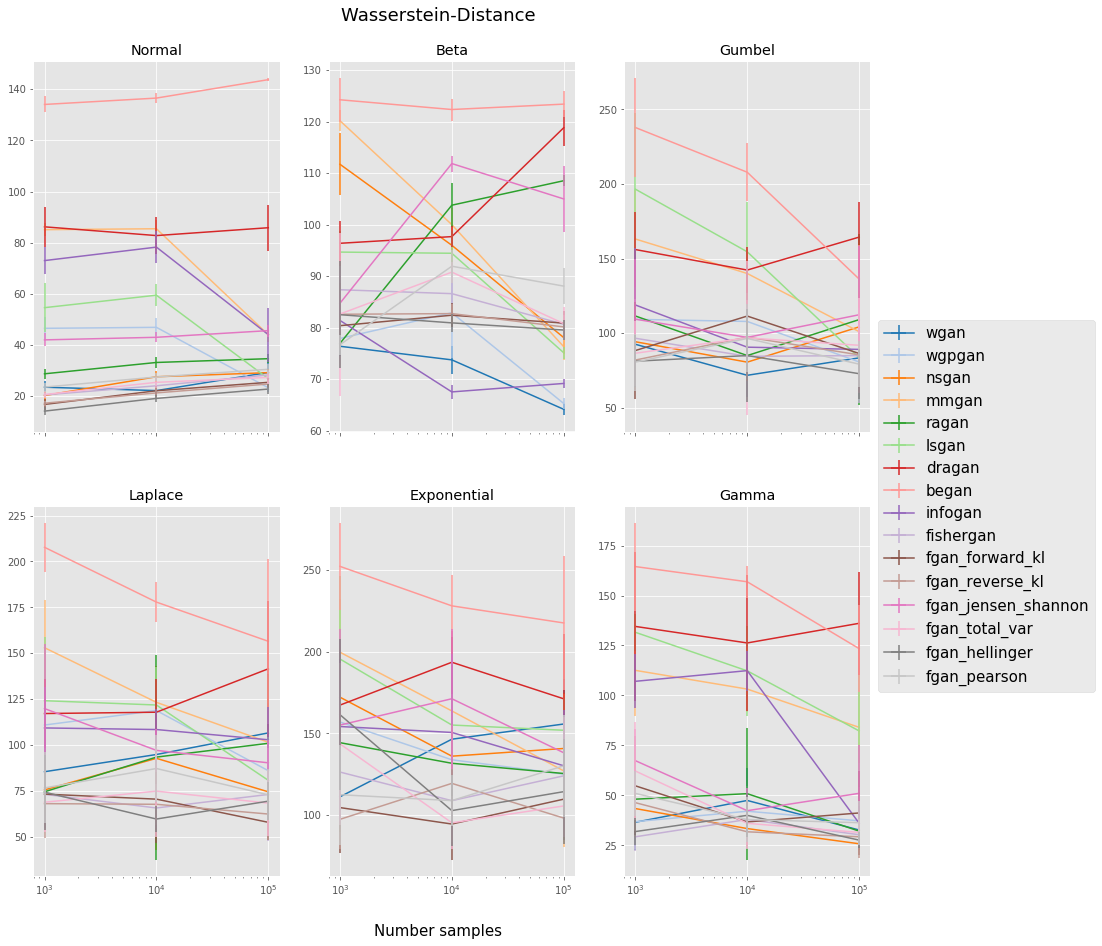

In [122]:
print(""" Plot mean minimum performance with error bars as a function of number samples """)

for metric in distance_metrics:
    
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(15,15))
                
    for d_idx, distribution in enumerate(distributions):

        for idx, model_name in enumerate(model_names):

            x, y, yerr = [], [], []
            for key, val in param_dict[metric][model_name][distribution].items():
                if key == 'performance':
                    continue

                mu, err = val.split('±')
                x.append(float(key)), y.append(float(mu)), yerr.append(float(err))

            axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].errorbar(x, y, xerr=0, yerr=yerr,
                                                                  barsabove=True, label=model_name,
                                                                  c=palette[idx], ecolor=palette[idx])
            axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].set_title("{0}".format(distribution.capitalize()))

    plt.xscale('log')
    fig.suptitle("{0}".format(metric), x=0.5, y=0.93, fontsize=18)
    fig.text(0.5, 0.07, "Number samples", ha='center', fontsize=15)
    plt.legend(loc='center left', bbox_to_anchor=(1, 1), fontsize=15)
    plt.savefig('../graphs/multivariate/samplesfnc_{0}_{1}_.png'.format(metric, 128), dpi=100)
    plt.show()
    print('\n')

In [124]:
print(""" Get number hyperparameter settings """)
print('1st entry: 1k samples, 2nd: 10k, 3rd: 100k')
print('Format: learning rate, hidden dim, bsize')


for metric in distance_metrics:
    
    print('\n======================')
    print('{0}'.format(metric))
    print('======================\n')
                
    for distribution in distributions:
        
        for model_name in model_names:
                    
            for samples, optimal in [(1000, optimal_1000), (10000, optimal_10000), (100000, optimal_100000)]:
                
                if 'params' not in param_dict[model_name][distribution][metric]:
                    param_dict[model_name][distribution][metric]['params'] = ''
                
                param_dict[model_name][distribution][metric]['params'] += ('_'.join([str(i) for i in optimal[model_name][distribution][metric]['parameters']]) + '\n')
        
    print(tabulate([[key, param_dict[key]['normal'][metric]['params'], param_dict[key]['beta'][metric]['params'], param_dict[key]['gumbel'][metric]['params'],
                          param_dict[key]['laplace'][metric]['params'], param_dict[key]['exponential'][metric]['params'], param_dict[key]['gamma'][metric]['params']]
                     for key in model_names],
                    headers=['Model', 'Normal', 'Beta', 'Gumbel', 'Laplace', 'Exponential', 'Gamma'], tablefmt='fancy_grid'))

 Get number hyperparameter settings 
1st entry: 1k samples, 2nd: 10k, 3rd: 100k
Format: learning rate, hidden dim, bsize

KL-Divergence

╒═════════════════════╤══════════════════╤══════════════════╤══════════════════╤══════════════════╤══════════════════╤══════════════════╕
│ Model               │ Normal           │ Beta             │ Gumbel           │ Laplace          │ Exponential      │ Gamma            │
╞═════════════════════╪══════════════════╪══════════════════╪══════════════════╪══════════════════╪══════════════════╪══════════════════╡
│ wgan                │ 0.00025_512_1024 │ 0.00025_512_1024 │ 0.0025_32_1024   │ 0.00025_512_1024 │ 0.00025_256_1024 │ 0.00025_256_1024 │
│                     │ 0.025_512_1024   │ 0.00025_256_1024 │ 0.0025_32_1024   │ 0.00025_512_1024 │ 0.00025_128_1024 │ 0.0025_32_1024   │
│                     │ 0.00025_128_1024 │ 0.00025_256_1024 │ 0.0025_32_1024   │ 0.00025_256_1024 │ 0.00025_64_1024  │ 0.00025_32_1024  │
├─────────────────────┼────────────